In [1]:
# API key ID: otlwwfxero72fkms03hi49x2
# API key secret: 5qbnpzqphl1y8bz6eggxraxlzlnbnhso49bro4925r1rpxj6sn
# app token: 8y23ArYxg4pcvOMgWzMFSC0nB
# secret app token: pZgwEL4lKm2r1s868Saz3EJ1ebpTKy-FzglU

# crime data docs: https://dev.socrata.com/foundry/data.cityofchicago.org/9hwr-2zxp

# make sure to install these packages before running:
!pip install pandas
!pip install sodapy
!pip install category_encoders

In [2]:
import pandas as pd
import sodapy
from sodapy import Socrata
import statistics
pd.set_option('display.max_columns', 500)

In [3]:
# crime_url = "https://data.cityofchicago.org/resource/9hwr-2zxp.json"


app_token = "8y23ArYxg4pcvOMgWzMFSC0nB"

# Example authenticated client (needed for non-public datasets):
client = Socrata("data.cityofchicago.org",
                 app_token, 
                 username="ch35@illinois.edu",
                 password="68M8rz3vF!StBjD")


# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("9hwr-2zxp", limit = 250000)

# Convert to pandas DataFrame
crime_df = pd.DataFrame.from_records(results)

print(crime_df.shape)

(202180, 22)


# Logistic Regression

In [4]:
crime_df.head()

,date,location,district,block,y_coordinate,latitude,description,location_description,updated_on,community_area,iucr,x_coordinate,ward,case_number,year,domestic,fbi_code,longitude,beat,primary_type,arrest,id
0,2022-11-10T23:52:00.000,"{'latitude': '41.684789786', 'human_address': ...",022,016XX W 115TH ST,1828441,41.684789786,TO PROPERTY,BAR OR TAVERN,2022-11-17T15:49:42.000,75,1310,1167266,34,JF470191,2022,False,14,-87.6633151,2234,CRIMINAL DAMAGE,False,12889112
1,2022-11-10T23:51:00.000,"{'latitude': '41.927622911', 'human_address': ...",019,017XX W ALTGELD ST,1916912,41.927622911,POSSESS - CANNABIS MORE THAN 30 GRAMS,STREET,2022-11-17T15:49:42.000,7,1812,1164516,32,JF470214,2022,False,18,-87.670885873,1931,NARCOTICS,True,12889088
2,2022-11-10T23:45:00.000,"{'latitude': '41.751822096', 'human_address': ...",006,078XX S PEORIA ST,1852903,41.751822096,TO VEHICLE,ALLEY,2022-11-17T15:49:42.000,71,1320,1171664,17,JF470206,2022,False,14,-87.646500811,0621,CRIMINAL DAMAGE,False,12889140
3,2022-11-10T23:45:00.000,"{'latitude': '41.903378801', 'human_address': ...",014,012XX N HOYNE AVE,1908059,41.903378801,AGGRAVATED - OTHER DANGEROUS WEAPON,STREET,2022-11-17T15:49:42.000,24,0430,1162183,1,JF470208,2022,False,04B,-87.679706644,1424,BATTERY,False,12889085
4,2022-11-10T23:45:00.000,"{'latitude': '41.943056436', 'human_address': ...",019,033XX N HALSTED ST,1922582,41.943056436,POCKET-PICKING,BAR OR TAVERN,2022-11-17T15:49:42.000,6,0870,1170328,44,JF470652,2022,False,06,-87.649362967,1925,THEFT,False,12889992


In [5]:
#creating variable for month
month = [i[0:7] for i in crime_df.date]

In [6]:
#adding to data frame
crime_df["month"] = month

In [7]:
#dropping irrelevant variables
crime_df_clean = crime_df.drop(["date", "location", "block", "updated_on", "case_number", "year", "id"], axis = 1)
crime_df_clean.head()

,district,y_coordinate,latitude,description,location_description,community_area,iucr,x_coordinate,ward,domestic,fbi_code,longitude,beat,primary_type,arrest,month
0,022,1828441,41.684789786,TO PROPERTY,BAR OR TAVERN,75,1310,1167266,34,False,14,-87.6633151,2234,CRIMINAL DAMAGE,False,2022-11
1,019,1916912,41.927622911,POSSESS - CANNABIS MORE THAN 30 GRAMS,STREET,7,1812,1164516,32,False,18,-87.670885873,1931,NARCOTICS,True,2022-11
2,006,1852903,41.751822096,TO VEHICLE,ALLEY,71,1320,1171664,17,False,14,-87.646500811,0621,CRIMINAL DAMAGE,False,2022-11
3,014,1908059,41.903378801,AGGRAVATED - OTHER DANGEROUS WEAPON,STREET,24,0430,1162183,1,False,04B,-87.679706644,1424,BATTERY,False,2022-11
4,019,1922582,41.943056436,POCKET-PICKING,BAR OR TAVERN,6,0870,1170328,44,False,06,-87.649362967,1925,THEFT,False,2022-11


## Removing Categorical Variables with High Cardinality (50+ Levels)

In [8]:
crime_df_clean.dtypes

district                object
y_coordinate            object
latitude                object
description             object
location_description    object
community_area          object
iucr                    object
x_coordinate            object
ward                    object
domestic                  bool
fbi_code                object
longitude               object
beat                    object
primary_type            object
arrest                    bool
month                   object
dtype: object

In [9]:
#converting variables to numeric
num_vars = ["y_coordinate", "x_coordinate", "latitude", "longitude"]
for i in num_vars:
    crime_df_clean[i] = crime_df_clean[i].astype("float")
crime_df_clean.dtypes

district                 object
y_coordinate            float64
latitude                float64
description              object
location_description     object
community_area           object
iucr                     object
x_coordinate            float64
ward                     object
domestic                   bool
fbi_code                 object
longitude               float64
beat                     object
primary_type             object
arrest                     bool
month                    object
dtype: object

In [10]:
#converting boolean variables to binary categorical variables
crime_df_clean["domestic"] = crime_df_clean["domestic"].astype(int)
crime_df_clean["arrest"] = crime_df_clean["arrest"].astype(int)
crime_df_clean.dtypes

district                 object
y_coordinate            float64
latitude                float64
description              object
location_description     object
community_area           object
iucr                     object
x_coordinate            float64
ward                     object
domestic                  int64
fbi_code                 object
longitude               float64
beat                     object
primary_type             object
arrest                    int64
month                    object
dtype: object

In [11]:
crime_df_clean["arrest"].dtypes == "O"

False

In [12]:
#storing list of cateogorical variables with high cardinality
high_card = [var for var in crime_df_clean.columns if len(crime_df_clean[var].value_counts()) >= 50 and crime_df_clean[var].dtypes == "O"]
high_card

['description',
 'location_description',
 'community_area',
 'iucr',
 'ward',
 'beat']

In [13]:
#dropping from set
crime_df_new = crime_df_clean.drop(high_card, axis = 1)
crime_df_new.head()

,district,y_coordinate,latitude,x_coordinate,domestic,fbi_code,longitude,primary_type,arrest,month
0,022,1828441.0,41.684790,1167266.0,0,14,-87.663315,CRIMINAL DAMAGE,0,2022-11
1,019,1916912.0,41.927623,1164516.0,0,18,-87.670886,NARCOTICS,1,2022-11
2,006,1852903.0,41.751822,1171664.0,0,14,-87.646501,CRIMINAL DAMAGE,0,2022-11
3,014,1908059.0,41.903379,1162183.0,0,04B,-87.679707,BATTERY,0,2022-11
4,019,1922582.0,41.943056,1170328.0,0,06,-87.649363,THEFT,0,2022-11


## Binning Categorical Variables
#### Goal is to group levels together if they share a similar target rate to establish bin credibility (at least 1% of observations in each bin)

In [14]:
cat_vars = [var for var in crime_df_new.columns if crime_df_new[var].dtypes == "O"]
cat_vars

['district', 'fbi_code', 'primary_type', 'month']

In [15]:
#district
pd.DataFrame({"District": crime_df_new["district"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["district"] == i]), 3) for i in crime_df_new["district"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["district"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["district"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,District,Target Rate,Proportion
22,16,0.000,0.000
7,019,0.072,0.051
2,012,0.082,0.059
10,002,0.086,0.049
21,020,0.087,0.021
1,008,0.091,0.062
8,003,0.092,0.050
3,004,0.093,0.059
19,022,0.099,0.032
17,024,0.099,0.036


##### Decision: 16 + 019, 011 + 031, all others can remain on their own

In [16]:
#FBI Code
pd.DataFrame({"FBI Code": crime_df_new["fbi_code"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["fbi_code"] == i]), 3) for i in crime_df_new["fbi_code"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["fbi_code"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["fbi_code"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,FBI Code,Target Rate,Proportion
23,12,0.000,0.000
13,10,0.007,0.009
6,11,0.013,0.053
14,02,0.024,0.007
3,07,0.025,0.083
2,14,0.032,0.115
0,06,0.035,0.232
10,05,0.038,0.032
8,03,0.048,0.037
15,17,0.052,0.007


##### Decision: Variable incredibly similar to the variable below, we'll drop this one

In [17]:
crime_df_new = crime_df_new.drop(["fbi_code"], axis = 1)
crime_df_new.head()

,district,y_coordinate,latitude,x_coordinate,domestic,longitude,primary_type,arrest,month
0,022,1828441.0,41.684790,1167266.0,0,-87.663315,CRIMINAL DAMAGE,0,2022-11
1,019,1916912.0,41.927623,1164516.0,0,-87.670886,NARCOTICS,1,2022-11
2,006,1852903.0,41.751822,1171664.0,0,-87.646501,CRIMINAL DAMAGE,0,2022-11
3,014,1908059.0,41.903379,1162183.0,0,-87.679707,BATTERY,0,2022-11
4,019,1922582.0,41.943056,1170328.0,0,-87.649363,THEFT,0,2022-11


In [18]:
#Primary Type
pd.DataFrame({"Primary Type": crime_df_new["primary_type"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["primary_type"] == i]), 3) for i in crime_df_new["primary_type"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["primary_type"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["primary_type"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,Primary Type,Target Rate,Proportion
26,HUMAN TRAFFICKING,0.000,0.000
23,INTIMIDATION,0.007,0.001
5,DECEPTIVE PRACTICE,0.015,0.063
13,CRIMINAL SEXUAL ASSAULT,0.023,0.007
4,MOTOR VEHICLE THEFT,0.025,0.083
2,CRIMINAL DAMAGE,0.032,0.115
0,THEFT,0.035,0.232
9,BURGLARY,0.038,0.032
18,STALKING,0.044,0.002
8,ROBBERY,0.048,0.037


##### Decision: Bottom 5, Next 5, Next 7, Next 2, Next 5, Last 7

In [19]:
#Month
pd.DataFrame({"Month": crime_df_new["month"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["month"] == i]), 3) for i in crime_df_new["month"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["month"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["month"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,Month,Target Rate,Proportion
10,2022-11,0.080,0.034
0,2022-10,0.089,0.111
3,2022-09,0.101,0.108
1,2022-07,0.104,0.109
2,2022-08,0.105,0.109
8,2022-01,0.111,0.076
4,2022-06,0.118,0.101
6,2022-03,0.121,0.090
7,2022-04,0.130,0.088
5,2022-05,0.138,0.099


##### Decision: Bins good to remain on their own, may consider seasonal binning later

### Implementing Bins

In [20]:
#district
crime_df_new.loc[crime_df_new["district"].isin(["16", "019"]), "district"] = "16/019"
crime_df_new.loc[crime_df_new["district"].isin(["011", "031"]), "district"] = "011/031"

In [21]:
#checking new values
pd.DataFrame({"District": crime_df_new["district"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["district"] == i]), 3) for i in crime_df_new["district"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["district"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["district"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,District,Target Rate,Proportion
7,16/019,0.072,0.051
2,012,0.082,0.059
10,002,0.086,0.049
21,020,0.087,0.021
1,008,0.091,0.062
8,003,0.092,0.050
3,004,0.093,0.059
19,022,0.099,0.032
17,024,0.099,0.036
0,006,0.104,0.062


In [22]:
#Primary Type
crime_df_new.loc[crime_df_new["primary_type"].isin(["HUMAN TRAFFICKING", "INTIMIDATION", "DECEPTIVE PRACTICE", "CRIMINAL SEXUAL ASSAULT", "MOTOR VEHICLE THEFT"]), "primary_type"] = "bin1"
crime_df_new.loc[crime_df_new["primary_type"].isin(["CRIMINAL DAMAGE", "THEFT", "BURGLARY", "STALKING", "ROBBERY"]), "primary_type"] = "bin2"
crime_df_new.loc[crime_df_new["primary_type"].isin(["OFFENSE INVOLVING CHILDREN", "SEX OFFENSE", "ARSON", "KIDNAPPING", "ASSAULT", "BATTERY", "OTHER OFFENSE"]), "primary_type"] = "bin3"
crime_df_new.loc[crime_df_new["primary_type"].isin(["HOMICIDE", "CRIMINAL TRESPASS"]), "primary_type"] = "bin4"
crime_df_new.loc[crime_df_new["primary_type"].isin(["OTHER NARCOTIC VIOLATION", "PUBLIC PEACE VIOLATION", "NON-CRIMINAL", "WEAPONS VIOLATION", "OBSCENITY"]), "primary_type"] = "bin5"
crime_df_new.loc[crime_df_new["primary_type"].isin(["PUBLIC INDECENCY", "GAMBLING", "INTERFERENCE WITH PUBLIC OFFICER", "NARCOTICS", "CONCEALED CARRY LICENSE VIOLATION", "LIQUOR LAW VIOLATION", "PROSTITUTION"]), "primary_type"] = "bin6"


In [23]:
#checking new values
pd.DataFrame({"Primary Type": crime_df_new["primary_type"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["primary_type"] == i]), 3) for i in crime_df_new["primary_type"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["primary_type"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["primary_type"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,Primary Type,Target Rate,Proportion
2,bin1,0.020,0.153
0,bin2,0.036,0.418
1,bin3,0.124,0.345
5,bin4,0.289,0.021
3,bin5,0.612,0.042
4,bin6,0.951,0.022


# WoE (Weight of Evidence) Coding Categorical Variables
### Converts categoricals to numerics to allow their use in the model

In [24]:
#dropping na values
crime_df_new = crime_df_new.dropna()

In [25]:
#train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(crime_df_new.drop(["arrest"], axis = 1), crime_df_new["arrest"], shuffle=True)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(150574, 8)
(50192, 8)
(150574,)
(50192,)


In [27]:
#making sure overall target rates are the same
print(statistics.mean(y_train.astype(int)))
print(statistics.mean(y_test.astype(int)))

0.11261572383014332
0.11631335671023271


In [28]:
#variables to be woe coded
cat_vars_new = [var for var in crime_df_new if crime_df_new[var].dtypes == "O" or var == "domestic"]
cat_vars_new

['district', 'domestic', 'primary_type', 'month']

In [29]:
import category_encoders as ce

In [30]:
#implementing woe coding
woe = ce.WOEEncoder(cols = cat_vars_new)
woe.fit(X_train, y_train)
train_woe = woe.transform(X_train, y_train)
test_woe = woe.transform(X_test)

In [31]:
train_woe.head()

,district,y_coordinate,latitude,x_coordinate,domestic,longitude,primary_type,month
27314,-0.109762,1874271.0,41.810785,1156133.0,-0.024032,-87.702841,-1.239577,-0.271443
188120,-0.301641,1873627.0,41.808541,1178398.0,-0.024032,-87.621195,-1.777611,-0.011429
96502,-0.108569,1853029.0,41.751967,1180605.0,-0.024032,-87.613733,-1.777611,0.036947
111846,-0.220858,1855006.0,41.757014,1196440.0,-0.024032,-87.555640,-1.777611,0.036947
92099,-0.457583,1920428.0,41.937140,1170608.0,-0.024032,-87.648397,-1.777611,-0.102124


In [32]:
test_woe.head()

,district,y_coordinate,latitude,x_coordinate,domestic,longitude,primary_type,month
180735,0.074210,1897911.0,41.875212,1176884.0,0.102030,-87.626014,0.105908,0.252105
82822,-0.457583,1917861.0,41.930023,1173915.0,-0.024032,-87.636320,0.105908,-0.102124
34606,-0.040162,1915884.0,41.924899,1159880.0,-0.024032,-87.687950,-1.777611,-0.123328
100955,-0.457583,1931169.0,41.966653,1168782.0,-0.024032,-87.654795,-1.239577,0.036947
124463,0.011964,1865614.0,41.786659,1173643.0,-0.024032,-87.638873,-1.239577,0.229296


# Univariate Screening
#### Generating univariate models to see which are predictive on their own

In [33]:
variables = train_woe.columns
import statsmodels.api as sm
from sklearn import metrics

In [34]:
#getting AUC for each individual variable
AUC = []
count = 0
for i in variables:
    mod = sm.GLM(y_train, train_woe[i], family=sm.families.Binomial()).fit()
    pred = mod.predict(test_woe[i])
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
    AUC.append(metrics.auc(fpr, tpr))

In [35]:
#displaying AUCs alongside their predictor
pd.DataFrame({"Predictor": train_woe.columns, "AUC": AUC})

,Predictor,AUC
0,district,0.578000
1,y_coordinate,0.500355
2,latitude,0.500213
3,x_coordinate,0.535105
4,domestic,0.509889
5,longitude,0.464626
6,primary_type,0.814979
7,month,0.543159


#### All predictors above .5 (random guessing) will be kept in for consideration

In [36]:
train_woe = train_woe.drop(["longitude"], axis = 1)
test_woe = test_woe.drop(["longitude"], axis = 1)
# what about y_coordinate and latitude?
train_woe = train_woe.drop(["y_coordinate"], axis = 1)
test_woe = test_woe.drop(["y_coordinate"], axis = 1)
train_woe = train_woe.drop(["latitude"], axis = 1)
test_woe = test_woe.drop(["latitude"], axis = 1)

In [37]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(train_woe, y_train)
y_pred = logreg.predict(test_woe)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(test_woe, y_test)))


Accuracy of logistic regression classifier on test set: 0.88


In [38]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[44354     0]
 [ 5838     0]]


In [39]:
tp_and_fn = confusion_matrix.sum(1)
tp_and_fp = confusion_matrix.sum(0)
tp = confusion_matrix.diagonal()

precision = tp / tp_and_fp
recall = tp / tp_and_fn

print(precision)
print(recall)

[0.88368664        nan]
[1. 0.]


/var/folders/lr/7699q93j6dl98rr5ftmz6p7r0000gn/T/ipykernel_23265/3082475497.py:5: RuntimeWarning: invalid value encountered in divide
  precision = tp / tp_and_fp


In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     44354
           1       0.00      0.00      0.00      5838

    accuracy                           0.88     50192
   macro avg       0.44      0.50      0.47     50192
weighted avg       0.78      0.88      0.83     50192



/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


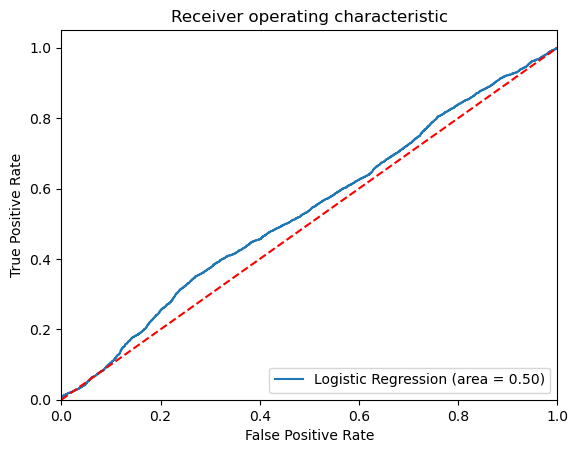

In [41]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(test_woe))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(test_woe)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Our ROC curve is very close to the ROC curve of a purely random classifier. Our curve is very bad.

In [62]:
# get random observation and prediction

print(test_woe.iloc[:1])
print(y_pred[0])

        district  x_coordinate  domestic  primary_type     month
180735   0.07421     1176884.0   0.10203      0.105908  0.252105
0


# Time Series (TO BE DONE)

In [42]:
#creating data frames
crime_agg = crime_df.groupby(by=month).size()
crime_sum = crime_df.groupby(by=month).sum()

In [43]:
#number of crimes per month
crime_agg

2022-01    15449
2022-02    15123
2022-03    18202
2022-04    17805
2022-05    19956
2022-06    20497
2022-07    21996
2022-08    21945
2022-09    21891
2022-10    22444
2022-11     6872
dtype: int64